<a href="https://colab.research.google.com/github/parrisem/Facial-Landmark-Detection/blob/main/Facial_Landmark_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import  History
from sklearn.cluster import KMeans
import skimage
from skimage import transform, util

# Data Loading

In [ ]:
!wget "http://users.sussex.ac.uk/~is321/training_images.npz" -O training_images.npz
# The test images (without points)
!wget "http://users.sussex.ac.uk/~is321/test_images.npz" -O test_images.npz
# The example images are here
!wget "http://users.sussex.ac.uk/~is321/examples.npz" -O examples.npz

# Load the data using np.load
data = np.load('training_images.npz', allow_pickle=True)
test = np.load('test_images.npz', allow_pickle=True)
examples = np.load('examples.npz', allow_pickle=True)

# Extract the images and points
images = data['images']
pts = data['points']
test_imgs = test['images']
example_imgs = examples['images']


--2020-08-23 13:17:40--  http://users.sussex.ac.uk/~is321/training_images.npz
Resolving users.sussex.ac.uk (users.sussex.ac.uk)... 139.184.14.119
Connecting to users.sussex.ac.uk (users.sussex.ac.uk)|139.184.14.119|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 349749643 (334M)
Saving to: ‘training_images.npz’

training_images.npz 100%[===================>] 333.55M  8.62MB/s    in 72s     

2020-08-23 13:18:54 (4.60 MB/s) - ‘training_images.npz’ saved [349749643/349749643]

--2020-08-23 13:18:55--  http://users.sussex.ac.uk/~is321/test_images.npz
Resolving users.sussex.ac.uk (users.sussex.ac.uk)... 139.184.14.119
Connecting to users.sussex.ac.uk (users.sussex.ac.uk)|139.184.14.119|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70032627 (67M)
Saving to: ‘test_images.npz’

test_images.npz     100%[===================>]  66.79M  8.31MB/s    in 26s     

2020-08-23 13:19:23 (2.54 MB/s) - ‘test_images.npz’ saved [70032627/70032627]

--2020

# Visualising the images and points

(2811, 240, 240, 3) (2811, 42, 2)


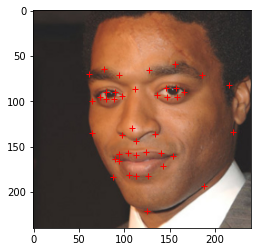

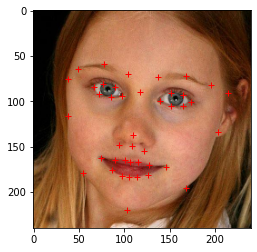

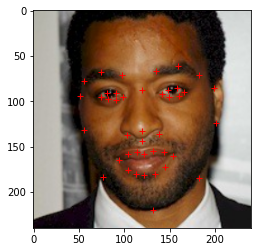

In [ ]:
# Displays some of the images from the data
print(images.shape, pts.shape)
def visualise_pts(img, pts):
  import matplotlib.pyplot as plt
  plt.imshow(img)
  plt.plot(pts[:, 0], pts[:, 1], '+r')
  plt.show()

for i in range(3):
  idx = np.random.randint(0, images.shape[0])
  visualise_pts(images[idx, ...], pts[idx, ...])
 

# Calculating Prediction Error and exporting results

In [ ]:
def euclid_dist(pred_pts, gt_pts):
  """
  Calculate the euclidean distance between pairs of points
  :param pred_pts: The predicted points
  :param gt_pts: The ground truth points
  :return: An array of shape (no_points,) containing the distance of each predicted point from the ground truth
  """
  import numpy as np
  pred_pts = np.reshape(pred_pts, (-1, 2))
  gt_pts = np.reshape(gt_pts, (-1, 2))
  return np.sqrt(np.sum(np.square(pred_pts - gt_pts), axis=-1))

In [ ]:
def save_as_csv(points, location = '.'):
  """
  Save the points out as a .csv file
  :param points: numpy array of shape (no_image, no_points, 2) to be saved
  :param location: Directory to save results.csv in. Default to current working directory
  """
  np.savetxt(location + '/results.csv', np.reshape(points, (points.shape[0], -1)), delimiter=',')


# Pre-processing Images and Points

Training images: (2811, 240, 240, 3)
Training points: (2811, 42, 2)
Testing images: (554, 240, 240, 3)
Grey training images: (2811, 240, 240)
Grey testing images: (554, 240, 240)


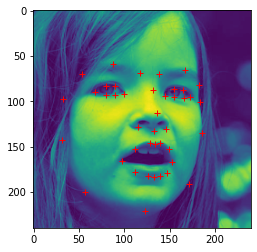

In [ ]:
# Making the training and testing images grayscale
copy_train_imgs = np.copy(images)
copy_train_pts = np.copy(pts)
copy_test_imgs = np.copy(test_imgs)

print("Training images:",copy_train_imgs.shape)
print("Training points:",copy_train_pts.shape)
print("Testing images:",copy_test_imgs.shape)

grey_train_imgs = []
grey_test_imgs = []

# training images
for i in range(0,copy_train_imgs.shape[0]):
  grey_train_imgs.append(cv2.cvtColor(copy_train_imgs[i], cv2.COLOR_BGR2GRAY))
grey_train_imgs = np.array(grey_train_imgs)
print("Grey training images:",grey_train_imgs.shape)

# testing images
for i in range(0,copy_test_imgs.shape[0]):
  grey_test_imgs.append(cv2.cvtColor(copy_test_imgs[i],cv2.COLOR_BGR2GRAY))
grey_test_imgs = np.array(grey_test_imgs)
print("Grey testing images:",grey_test_imgs.shape)


plt.imshow(grey_train_imgs[5])
plt.plot(copy_train_pts[5][:,0],copy_train_pts[5][:,1],'+r')
plt.show()


Rescaled grey image: (2811, 100, 100)
Rescaled grey image points: (2811, 42, 2)
Rescaled grey test image: (554, 100, 100)


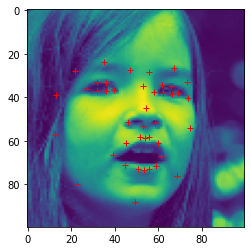

In [ ]:
# Rescaling the training and testing images and training points.
resc_gray_imgs = []
resc_pts = []
resc_gray_test_imgs = []

for i in range(0,grey_train_imgs.shape[0]):
  resc_gray_imgs.append(cv2.resize(grey_train_imgs[i],(100,100)))
for i in range(0,copy_train_pts.shape[0]):
  resc_pts.append(copy_train_pts[i]*[100/250,100/250])

for i in range(0,grey_test_imgs.shape[0]):
  resc_gray_test_imgs.append(cv2.resize(grey_test_imgs[i],(100,100)))

resc_gray_imgs = np.array(resc_gray_imgs)
resc_pts = np.array(resc_pts)
resc_gray_test_imgs = np.array(resc_gray_test_imgs)

print("Rescaled grey image:",resc_gray_imgs.shape)
print("Rescaled grey image points:",resc_pts.shape)
print("Rescaled grey test image:",resc_gray_test_imgs.shape)

plt. imshow(resc_gray_imgs[5])
plt.plot(resc_pts[5][:,0], resc_pts[5][:,1],'+r')
plt.show()

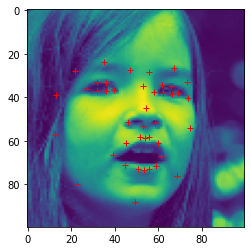

In [ ]:
# normalise training and testing image arrays.
norm_train_imgs = resc_gray_imgs/255
norm_train_pts = resc_pts/100-1
norm_test_imgs = resc_gray_test_imgs/255

plt.imshow(norm_train_imgs[5])
plt.plot((norm_train_pts[5][:,0]+1)*100,(norm_train_pts[5][:,1]+1)*100,'+r')
plt.show()

# CNN model

In [ ]:
history = History()
train_imgs_x = norm_train_imgs.reshape(norm_train_imgs.shape[0],100,100,1)
train_imgs_y = norm_train_pts.reshape(norm_train_pts.shape[0],-1)

In [ ]:
# first model
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', activation='relu', strides=1, input_shape=(100, 100, 1)))
model.add(MaxPooling2D(pool_size =(2,2)))

model.add(Conv2D(64,(3,3), padding='same', strides=1, activation='relu'))
model.add(MaxPooling2D(pool_size =(2,2)))

model.add(Conv2D(64, (3,3), padding='same',strides=1, activation='relu'))
model.add(MaxPooling2D(pool_size =(2,2)))

model.add(Conv2D(128,(3,3), padding='same',strides=1, activation='relu'))
model.add(MaxPooling2D(pool_size =(2,2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(84))
model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 128)       7

# Training the model

In [ ]:
history = model.fit(train_imgs_x, train_imgs_y, validation_split=0.3, batch_size=50, shuffle=True, epochs=150, verbose=1)

Epoch 1/150
40/40 [==============================] - 35s 881ms/step - loss: 0.0039 - accuracy: 0.7402 - val_loss: 0.0014 - val_accuracy: 0.8341
Epoch 2/150
40/40 [==============================] - 35s 881ms/step - loss: 0.0037 - accuracy: 0.7453 - val_loss: 0.0014 - val_accuracy: 0.8341
Epoch 3/150
40/40 [==============================] - 35s 884ms/step - loss: 0.0037 - accuracy: 0.7478 - val_loss: 0.0014 - val_accuracy: 0.8341
Epoch 4/150
40/40 [==============================] - 35s 881ms/step - loss: 0.0035 - accuracy: 0.7636 - val_loss: 0.0016 - val_accuracy: 0.8341
Epoch 5/150
40/40 [==============================] - 35s 882ms/step - loss: 0.0035 - accuracy: 0.7692 - val_loss: 0.0015 - val_accuracy: 0.8341
Epoch 6/150
40/40 [==============================] - 35s 881ms/step - loss: 0.0033 - accuracy: 0.7738 - val_loss: 0.0015 - val_accuracy: 0.8341
Epoch 7/150
40/40 [==============================] - 35s 884ms/step - loss: 0.0033 - accuracy: 0.7824 - val_loss: 0.0014 - val_accuracy:

In [ ]:
# epochs 100
# loss plot
plt.figure(figsize=(17,7))
plt.subplot(1,2,1)
plt.suptitle('Original Data', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=16)
plt.plot(history.history['loss'], color='r', label='Training Loss')
plt.plot(history.history['val_loss'], color='b', label='Validation Loss')
plt.legend(loc='upper right')

# accuracy plot
plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.xlabel('Epochs', fontsize=16)
plt.plot(history.history['accuracy'], color='r', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], color='b', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

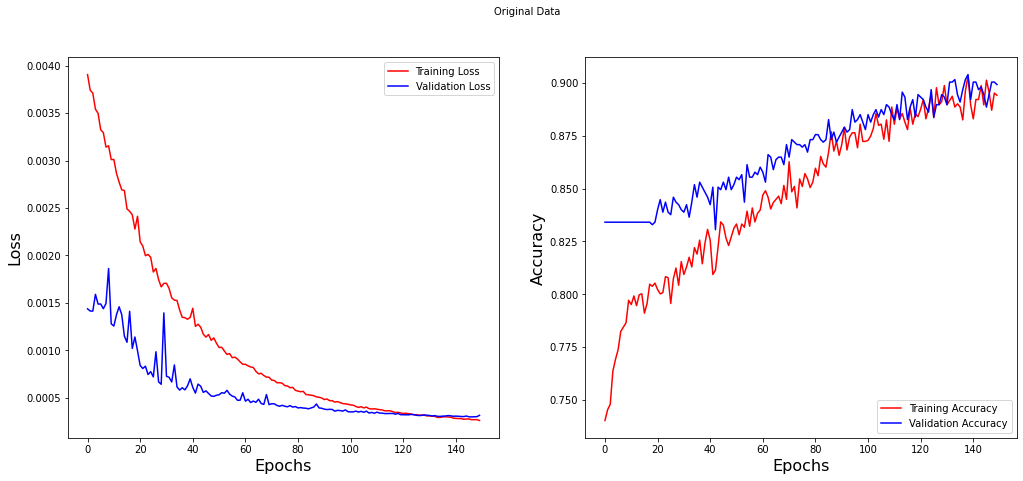

In [ ]:
#epochs 150
# loss plot
plt.figure(figsize=(17,7))
plt.subplot(1,2,1)
plt.suptitle('Original Data', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=16)
plt.plot(history.history['loss'], color='r', label='Training Loss')
plt.plot(history.history['val_loss'], color='b', label='Validation Loss')
plt.legend(loc='upper right')

# accuracy plot
plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.xlabel('Epochs', fontsize=16)
plt.plot(history.history['accuracy'], color='r', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], color='b', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# Predicting and saving the test images points

In [ ]:
pts_test = model.predict(norm_test_imgs.reshape(norm_test_imgs.shape[0], 100,100,1))
test_pts = pts_test.reshape(pts_test.shape[0],42,-1)
save_as_csv(test_pts)

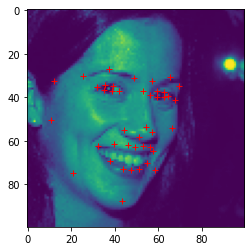

In [ ]:
#vizualise some of the test images with thier predicted points, epochs 100
plt.imshow(norm_test_imgs[444])
plt.plot((test_pts[444][:,0]+1)*100,(test_pts[444][:,1]+1)*100, '+r')
plt.show()

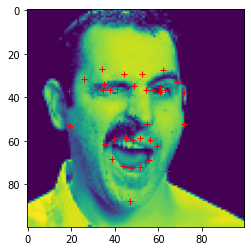

In [ ]:
#vizualise some of the test images with thier predicted points, epochs 150
plt.imshow(norm_test_imgs[300])
plt.plot((test_pts[300][:,0]+1)*100,(test_pts[300][:,1]+1)*100, '+r')
plt.show()

# Augmenting the training data

In [ ]:
# Rotating the images and points
def rotate_img_pts(img,pts):
   """
  Rotate the images and their points
  :param img: The image
  :param pts: The points
  :return: Tuple of the rotated images and the rotated points
  """
  new_img = np.copy(img)
  rot_pts = np.copy(pts)
  rot_img = skimage.transform.rotate(new_img, angle=90)
  for i in range(0,42):
    rot_pts = np.rot90(pts,2)

  return rot_img,rot_pts


In [ ]:
rot_train_imgs = []
rot_train_pts = []

for i in range(0,norm_train_imgs.shape[0]):
  rotated_imgs,rotated_pts = rotate_img_pts(norm_train_imgs[i],norm_train_pts[i])
  rot_train_imgs.append(rotated_imgs)
  rot_train_pts.append(rotated_pts)

rot_train_imgs = np.array(rot_train_imgs)
rot_train_pts = np.array(rot_train_pts)


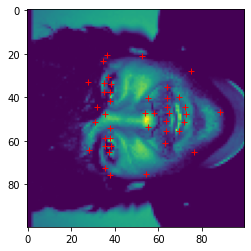

In [ ]:
plt.imshow(rot_train_imgs[3])
plt.plot((rot_train_pts[3][:,0]+1)*100,(rot_train_pts[3][:,1]+1)*100,'+r')
plt.show()

In [ ]:
new_training_imgs = np.concatenate((norm_train_imgs, rot_train_imgs))
new_training_pts = np.concatenate((norm_train_pts, rot_train_pts))
print(new_training_imgs.shape)
print(new_training_pts.shape)

(5622, 100, 100)
(5622, 42, 2)


In [ ]:
f_history = History()
f_train_imgs_x = new_training_imgs.reshape(new_training_imgs.shape[0],100,100,1)
f_train_imgs_y = new_training_pts.reshape(new_training_pts.shape[0],-1)

# Building final model

In [ ]:
# final model

f_model = Sequential()
f_model.add(Conv2D(32, (3,3), activation='relu', strides=1, input_shape=(100, 100, 1)))
f_model.add(MaxPooling2D(pool_size =(2,2)))

f_model.add(Conv2D(64,(3,3), strides=1, activation='relu'))
f_model.add(MaxPooling2D(pool_size =(2,2)))
f_model.add(Conv2D(64, (3,3), strides=1, activation='relu'))
f_model.add(MaxPooling2D(pool_size =(2,2)))

f_model.add(Conv2D(128,(3,3), strides=1, activation='relu'))
f_model.add(MaxPooling2D(pool_size =(2,2)))

f_model.add(Flatten())
f_model.add(Dense(512, activation='relu'))
f_model.add(Dropout(0.2))

f_model.add(Dense(84))
f_model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ['accuracy'])
f_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 98, 98, 32)        320       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 21, 21, 64)        36928     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 8, 8, 128)        

# Training final model

In [ ]:
f_history = f_model.fit(f_train_imgs_x,f_train_imgs_y, validation_split=0.3, batch_size=50, shuffle=True, epochs=150, verbose=1)

Epoch 1/150
79/79 [==============================] - 58s 732ms/step - loss: 2.4997e-04 - accuracy: 0.9098 - val_loss: 3.9383e-04 - val_accuracy: 0.9063
Epoch 2/150
79/79 [==============================] - 60s 762ms/step - loss: 2.4210e-04 - accuracy: 0.9133 - val_loss: 3.6757e-04 - val_accuracy: 0.9063
Epoch 3/150
79/79 [==============================] - 58s 728ms/step - loss: 2.3668e-04 - accuracy: 0.9039 - val_loss: 3.8518e-04 - val_accuracy: 0.9052
Epoch 4/150
79/79 [==============================] - 58s 729ms/step - loss: 2.3241e-04 - accuracy: 0.9116 - val_loss: 3.6373e-04 - val_accuracy: 0.9034
Epoch 5/150
79/79 [==============================] - 58s 730ms/step - loss: 2.2953e-04 - accuracy: 0.9126 - val_loss: 3.6898e-04 - val_accuracy: 0.9063
Epoch 6/150
79/79 [==============================] - 58s 728ms/step - loss: 2.2964e-04 - accuracy: 0.9075 - val_loss: 3.6875e-04 - val_accuracy: 0.9028
Epoch 7/150
79/79 [==============================] - 58s 729ms/step - loss: 2.2763e-04 -

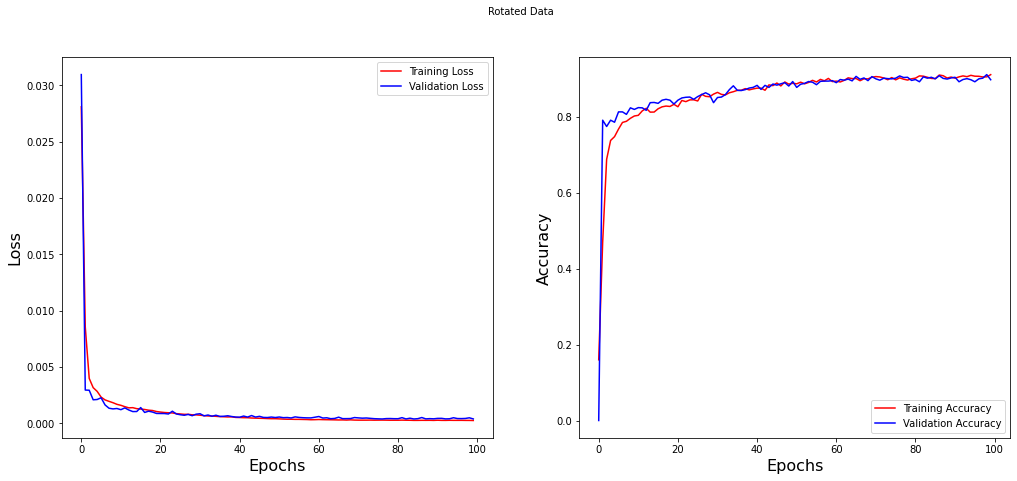

In [ ]:
# Epochs 100
# loss plot
plt.figure(figsize=(17,7))
plt.subplot(1,2,1)
plt.suptitle('Rotated Data', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=16)
plt.plot(f_history.history['loss'], color='r', label='Training Loss')
plt.plot(f_history.history['val_loss'], color='b', label='Validation Loss')
plt.legend(loc='upper right')

# accuracy plot
plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.xlabel('Epochs', fontsize=16)
plt.plot(f_history.history['accuracy'], color='r', label='Training Accuracy')
plt.plot(f_history.history['val_accuracy'], color='b', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

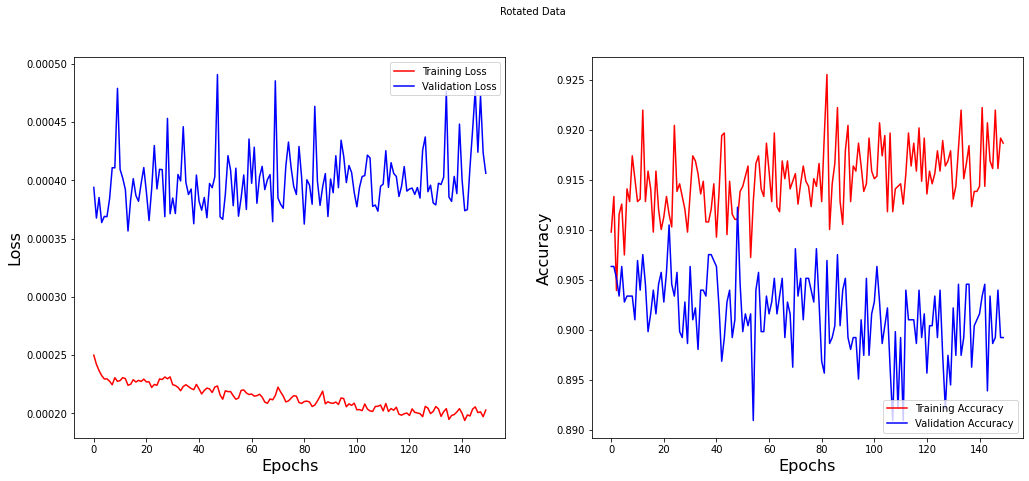

In [ ]:
# Epochs 150
# loss plot
plt.figure(figsize=(17,7))
plt.subplot(1,2,1)
plt.suptitle('Rotated Data', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=16)
plt.plot(f_history.history['loss'], color='r', label='Training Loss')
plt.plot(f_history.history['val_loss'], color='b', label='Validation Loss')
plt.legend(loc='upper right')

# accuracy plot
plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.xlabel('Epochs', fontsize=16)
plt.plot(f_history.history['accuracy'], color='r', label='Training Accuracy')
plt.plot(f_history.history['val_accuracy'], color='b', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# Predicting and saving the test points for final model

In [ ]:
pts_test_2 = f_model.predict(norm_test_imgs.reshape(norm_test_imgs.shape[0], 100,100,1))
test_pts_2 = pts_test_2.reshape(pts_test_2.shape[0],42,-1)
save_as_csv(test_pts_2)

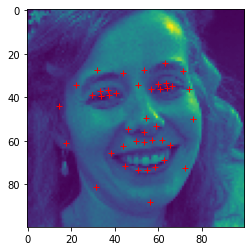

In [ ]:
#vizualise some of the test images with thie predicted points, epochs 100
plt.imshow(norm_test_imgs[300])
plt.plot((test_pts_2[300][:,0]+1)*100,(test_pts_2[300][:,1]+1)*100,'+r')
plt.show()

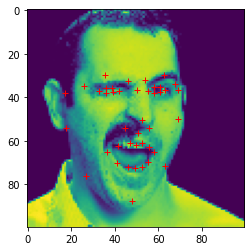

In [ ]:
#vizualise some of the test images with thie predicted points, epochs 150
plt.imshow(norm_test_imgs[300])
plt.plot((test_pts_2[300][:,0]+1)*100,(test_pts_2[300][:,1]+1)*100,'+r')
plt.show()

# Calculating Prediction Error and exporting results

In [ ]:
# Example 1
ed = f_model.predict(f_train_imgs_x)
ed = ed.reshape(ed.shape[0],42,-1)

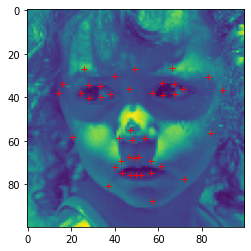

array([1.17550064, 0.77908927, 2.03748757, 3.44110829, 1.13366033,
       0.91014141, 1.73312475, 0.2015495 , 0.61556669, 0.33236307,
       2.5388408 , 1.81697002, 2.03885036, 0.94353645, 1.20870906,
       0.7729947 , 0.32816976, 0.42712146, 0.21466955, 1.09259529,
       0.82786175, 0.46876896, 0.41008715, 0.25167046, 0.13997711,
       0.36171586, 0.65615603, 0.08176438, 0.25468132, 0.09817696,
       0.81459174, 0.67423109, 0.24437503, 0.23332126, 0.42738125,
       1.34632472, 1.30923235, 1.0637504 , 0.64177171, 0.58776704,
       0.37150399, 0.59433334])

In [ ]:
plt.imshow(norm_train_imgs[1])
plt.plot((norm_train_pts[1][:,0]+1)*100,(norm_train_pts[1][:,1]+1)*100,'+r')
plt.show()

euclid_dist((ed[1]+1)*100,(norm_train_pts[1]+1)*100)

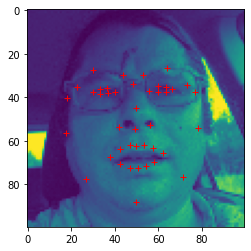

array([1.16416996, 1.11842114, 1.02600805, 0.4488785 , 0.88029399,
       1.71097343, 2.16387702, 1.34239124, 1.7122659 , 1.49242913,
       1.42325644, 0.38152889, 0.11297919, 0.4878338 , 1.62420198,
       1.22606534, 0.30444476, 0.84392867, 1.00502939, 1.2182592 ,
       1.01566673, 0.62929424, 0.52786121, 0.83001951, 0.76507841,
       0.43271275, 0.08043201, 0.83655279, 0.36677656, 0.53415142,
       0.57668766, 0.88461241, 0.46771036, 0.53986932, 0.56249538,
       0.29719118, 1.27712501, 1.215221  , 2.08558101, 1.57925689,
       1.03708563, 0.95358195])

In [ ]:
# Example 2
plt.imshow(norm_train_imgs[7])
plt.plot((norm_train_pts[7][:,0]+1)*100,(norm_train_pts[7][:,1]+1)*100,'+r')
plt.show()

euclid_dist((ed[7]+1)*100,(norm_train_pts[7]+1)*100)

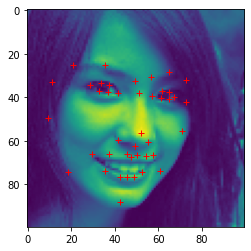

array([1.05544995, 1.93922844, 2.55353248, 0.19104591, 2.26857611,
       0.53203004, 0.96890768, 1.98552538, 0.31600952, 2.97292229,
       0.58537396, 1.7742241 , 1.24015377, 0.40512192, 1.02116373,
       0.32589384, 0.13506327, 0.04768373, 0.64718581, 0.56865098,
       0.33554467, 0.49496534, 0.93416766, 1.00366355, 0.60772633,
       0.7315088 , 0.81197256, 0.51773639, 0.60236176, 0.25795885,
       1.22147513, 0.33397689, 1.49715528, 0.53129003, 0.49457562,
       0.71790187, 1.0400289 , 1.29276034, 0.70104988, 0.43568827,
       1.00000951, 1.44968876])

In [ ]:
# Example 3
plt.imshow(norm_train_imgs[133])
plt.plot((norm_train_pts[133][:,0]+1)*100,(norm_train_pts[133][:,1]+1)*100,'+r')
plt.show()

euclid_dist((ed[133]+1)*100,(norm_train_pts[133]+1)*100)

# Face Segmentation System

In [ ]:
def img_segmentation(img,pts):
  """
  Fills the face in an image with colour using the points predicted by the model as its boundary
  :param img: The image
  :param pts: The predicted points
  """
  seg_img = np.zeros((100,100), dtype=np.uint8)
  bounds = pts

  fig, (ax1, ax2) = plt.subplots(1, 2)
  fig.suptitle('BEFORE & AFTER')
  cv2.fillPoly(seg_img, np.int32([bounds]), [255,255,255], lineType=4, shift=0)

  ax2.imshow(seg_img)
  ax1.imshow(img)


# Testing final model on example images

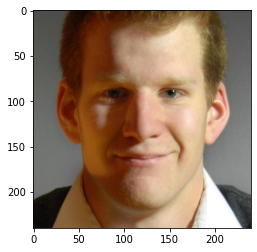

In [ ]:
# visualising the example images
example_imgs.shape

plt.imshow(example_imgs[1])
plt.show()

# Pre-processing example images

Grey example images: (6, 240, 240)
Rescaled grey example images: (6, 100, 100)
Normalized grey, rescaled example images: (6, 100, 100)


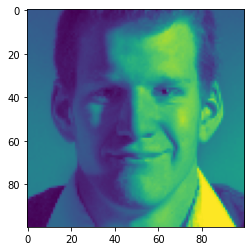

In [ ]:
# pre-processing the example images like I did with the training and testing images

gray_example_imgs = []
resc_example_imgs = []

# make grayscale
for i in range(0,example_imgs.shape[0]):
  gray_example_imgs.append(cv2.cvtColor(example_imgs[i],cv2.COLOR_BGR2GRAY))
gray_example_imgs = np.array(gray_example_imgs)
print("Grey example images:",gray_example_imgs.shape)

# resize
for i in range(0,gray_example_imgs.shape[0]):
  resc_example_imgs.append(cv2.resize(gray_example_imgs[i],(100,100)))
resc_example_imgs = np.array(resc_example_imgs)
print("Rescaled grey example images:", resc_example_imgs.shape)
plt.imshow(resc_example_imgs[1])

# normalize
norm_ex_imgs = resc_example_imgs/255
print("Normalized grey, rescaled example images:", norm_ex_imgs.shape)

plt.imshow(norm_ex_imgs[1])
plt.show()

# Predicting and saving the points for example images

In [ ]:
example_predict_pts = f_model.predict(norm_ex_imgs.reshape(norm_ex_imgs.shape[0],100,100,1))
ex_predict_pts = example_predict_pts.reshape(example_predict_pts.shape[0],42,2)
save_as_csv(ex_predict_pts)

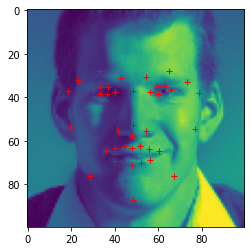

In [ ]:
# visualising the points on the image
plt.imshow(norm_ex_imgs[1])
plt.plot((ex_predict_pts[1][:,0]+1)*100,(ex_predict_pts[1][:,1]+1)*100,'+r')
plt.show()

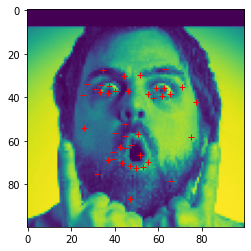

In [ ]:
# visualising the points on the image
plt.imshow(norm_ex_imgs[2])
plt.plot((ex_predict_pts[2][:,0]+1)*100,(ex_predict_pts[2][:,1]+1)*100,'+r')
plt.show()

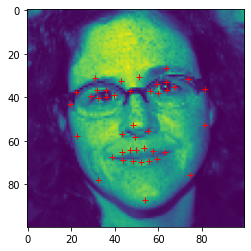

In [ ]:
# visualising the points on the image
plt.imshow(norm_ex_imgs[3])
plt.plot((ex_predict_pts[3][:,0]+1)*100,(ex_predict_pts[3][:,1]+1)*100,'+r')
plt.show()

# Applying Face Segmentation on example images

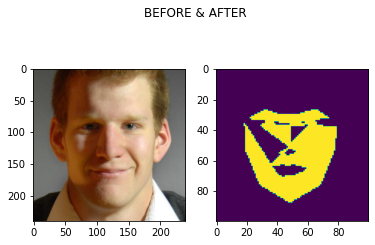

In [ ]:
img_seg(example_imgs[1],(ex_predict_pts[1]+1)*100)

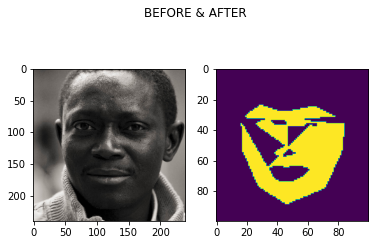

In [ ]:
img_seg(example_imgs[0],(ex_predict_pts[0]+1)*100)